## Dataloading

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from ast import literal_eval
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.rcParams.update({'font.size': 24})

### Load data

In [26]:
df = pd.read_csv('results.csv', index_col=False)

del df['Unnamed: 0']

a = []

df['target'] = df['target'].apply(literal_eval)
joe = df['target'].values
for v in joe:
    a.append(np.array(v))
joe = np.array(a).argmax(1)
df['target'] = joe

df['mean0'] = df['mean0'].astype('float64')
df['std0'] = df['std0'].astype('float64')
df['mean1'] = df['mean1'].astype('float64')
df['std1'] = df['std1'].astype('float64')
display(df.head())

,target,mean0,std0,mean1,std1,text
0,0,0.999086,0.000652,0.000914,0.000652,...
1,0,0.969981,0.012336,0.030019,0.012336,...
2,1,0.230962,0.083058,0.769038,0.083058,classics and is not only a <UNK> little 20 min...
3,0,0.982669,0.009936,0.017331,0.009936,<UNK> a nerd thing it's just an example of how...
4,1,0.135886,0.054573,0.864114,0.054573,<UNK> travels back towards the hospital but is...


In [27]:
def classify(x, threshold):
    mean = np.array([x['mean0'], x['mean1']])
    std = np.array([x['std0'], x['std1']])
    if (std[mean.argmax()] <= threshold):
        return mean.argmax()
    else:
        return -1

In [28]:
df['std1'].max()

In [29]:
from tqdm import tqdm

sns.set_style('whitegrid')

thresholds = list(np.arange(0,0.2,0.005))
precisions = []
recalls = []

for t in tqdm(thresholds):
    testdf = df
    testdf['test'] = testdf.apply(classify, args=[t], axis=1)
    certain = df[df['test']!=-1]
#     print(len(certain))
    precision = certain['target'] == certain['test']
#     print('precision',precision.mean())
    recall = len(certain)/12500
#     print('recall',recall.mean())
    precisions.append(precision.mean())
    recalls.append(recall)

datf = pd.DataFrame({'threshold':thresholds[1:], 'precision':precisions[1:], 'recall':recalls[1:]})
fig, ax = plt.subplots(figsize=(15,10))
sns.lineplot(data=datf, x='threshold', y='precision')
sns.lineplot(data=datf, x='threshold', y='recall')
plt.title('Precision and Recall with uncertainty threshold')
plt.legend(['precision','recall'])
# plt.set_xlabel('confidence threshold')
# plt.set_ylabel('precision/recall')

In [ ]:
testdf = df
testdf['test'] = testdf.apply(classify, args=[0.075], axis=1)
certain = df[df['test']!=-1]
#     print(len(certain))
precision = certain['target'] == certain['test']
#     print('precision',precision.mean())
recall = len(certain)/12500

print('precision',precision.mean())
print('recall',recall)

precision 0.9286486486486486
recall 0.814


In [30]:
df['test'] = df.apply(classify, args=[1], axis=1)
sortd = df.sort_values(['std0'])
sortd = sortd[sortd['target'] != sortd['test']]
sortd = sortd.reset_index(drop=True)
sortd.head()

,target,mean0,std0,mean1,std1,text,test
0,1,0.998759,0.000885,0.001241,0.000885,...,0
1,0,0.001844,0.001418,0.998156,0.001418,...,1
2,0,0.002696,0.002111,0.997304,0.002111,want to get a good idea of how the actual germ...,1
3,0,0.003563,0.002438,0.996437,0.002438,...,1
4,1,0.994419,0.003092,0.005581,0.003092,wheelchair runs over it there are loads of <UN...,0


In [ ]:
i = 0

4
wheelchair runs over it there are loads of <UNK> someone has their guts removed with a hook there's a rotten corpse complete with <UNK> someone hand is cut off someone has their head <UNK> in their eye falls out a gory death by piano wire as it <UNK> through <UNK> throat there are loads of severed limbs <UNK> of blood <UNK> around a scene of some cats eating brains there's more as well having said that some of the special effects are a bit fake look cheesy br br with a supposed budget of around 100 000 it shows this is pretty cheap looking it has no visual style or artistic merit but then again why would you want those when you can see a nazi orgy sequence wall to wall gore the acting in this is terrible including fulci br br un <UNK> <UNK> is a top film if your a gore <UNK> like me however if your looking for something with a little bit more substance or indeed any substance then this ones not for you this is the sort of film which <UNK> people straight down the middle you'll either

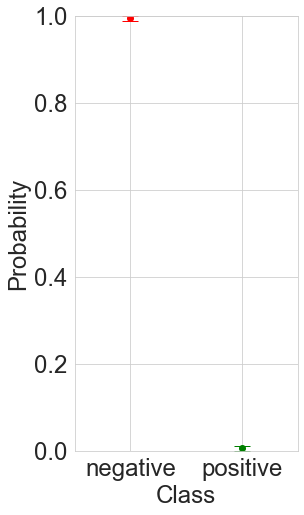

In [36]:
print(i)
s = sortd.iloc[i]
print(s['text'])
if s['target'] == 0:
    colors = ['green', 'red']
else:
    colors = ['red', 'green']

x_0 = [0]
x_1 = [1]
y_0 = [s['mean0']]
y_1 = [s['mean1']]
err_0 = [s['std0']*2]
err_1 = [s['std1']*2]
print(err_0, err_1)
plt.figure(figsize=(4,8))
plt.errorbar(x_0, y_0, yerr=err_0, fmt='o', capsize=8, color=colors[0])
plt.errorbar(x_1, y_1, yerr=err_1, fmt='o', capsize=8, color=colors[1])

plt.xticks([0, 1], ['negative', 'positive'])
plt.ylim([0,1])
plt.xlim([-0.5, 1.5])
plt.xlabel('Class')
plt.ylabel('Probability')

i += 1

In [ ]:
df['y_pred'] = df.apply(classify, args=[0.075], axis=1)

for t in thresholds:
    testdf = df
    testdf['test'] = testdf.apply(classify, args=[1-t], axis=1)
    certain = df[df['test']!=-1]
    precision = certain['target'] == certain['test']
#     print('precision',precision.mean())
    recall = df['target'] == df['test']
#     print('recall',recall.mean())
    precisions.append(precision.mean())
    recalls.append(recall.mean())
    
plt.plot(thresholds, precisions)
plt.plot(thresholds, recalls)
plt.title('Precision and Recall with confidence threshold')
plt.legend(['precision','recall'])
plt.set_xlabel('confidence threshold')
plt.set_ylabel('precision/recall')

In [ ]:
i = 62

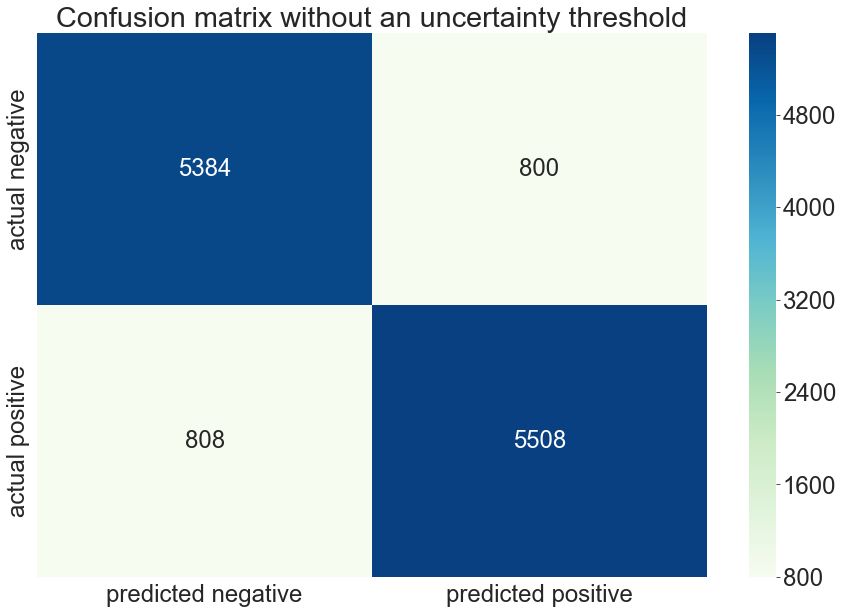

In [18]:
df['y_pred'] = df.apply(classify, args=[1], axis=1)

tdf = df[df['y_pred'] != -1]

cm = confusion_matrix(tdf['target'].values, tdf['y_pred'].values)

df_cm = pd.DataFrame(cm, index = ['negative', 'positive'],
                  columns = ['predicted negative', 'predicted positive'])


fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(df_cm, annot=True, fmt='g', cmap='GnBu', ax=ax)
plt.yticks(np.arange(2)+0.5,['actual negative', 'actual positive'], va='center')
plt.title('Confusion matrix without an uncertainty threshold')
plt.show()

# Mean TF-IDF per document

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from keras.datasets import imdb

In [ ]:
# calculate td-idf

X = df['text'].tolist()

# vectorizer = TfidfVectorizer()
vectorizer = TfidfVectorizer(stop_words='english')

X_tfidf = vectorizer.fit_transform(X)

In [ ]:
# compute the mean tf-idf per document

tf_idf_avg = []
for document in X_tfidf:
    tf_idf_avg.append(document.mean())

print(tf_idf_avg[:10])

In [ ]:
# plot the tf-idf of the first n documents

n = 50
y = tf_idf_avg[:n]
x = np.arange(n)
fig, ax = plt.subplots()
ax.bar(x, y)
plt.xlabel('Document')
plt.ylabel('tf-idf')
plt.show()

In [ ]:
# plot the average tf-idf of the correctly and incorrecyly classified reviews

# use a high threshold
threshold = 0.15

sum_correct = 0
sum_incorrect = 0

tfidf_sum_correct = 0
tfidf_sum_incorrect = 0

for index, row in df.iterrows():
    target = row['target']
    predicted = classify(row, threshold)
    if predicted == target:
        tfidf_sum_correct += tf_idf_avg[index]
        sum_correct += 1
    else:
        sum_incorrect += 1
        tfidf_sum_incorrect += tf_idf_avg[index]

print("average of mean correctly classified reviews:", tfidf_sum_correct/sum_correct)
print("average of mean incorrectly classified reviews:", tfidf_sum_incorrect/sum_incorrect)
# print(tfidf_sum_correct)
# print(tfidf_sum_incorrect)
# print('--------')
# print(sum_correct)
# print(sum_incorrect)

In [ ]:
# cluster the documents based on their tf-idf

clusters=2
model = KMeans(n_clusters=clusters, max_iter=100)
model.fit(X_tfidf)

In [ ]:
# put the results in a pandas dataframe

results = pd.DataFrame({
    'cluster': model.labels_
})
results.head()

In [ ]:
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()

for i in range(clusters):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(" %s" % terms[ind])

In [ ]:
test_1 = "i liked the characters, it was a good movie"
print("test 1:", test_1)
test_1 = vectorizer.transform([test_1])
predicted_1 = model.predict(test_1)
print("prediction", predicted_1)

test_2 = "bad, really bad, i hated it"
print("test 2:", test_2)
test_2 = vectorizer.transform([test_2])
predicted_2 = model.predict(test_2)
print("prediction", predicted_2)

# Document length

In [ ]:
x = np.arange(len(X_train))
y = []
for review in X_train:
    y.append(len(review.split()))

fig, ax = plt.subplots()
ax.bar(x, y)
plt.xlabel('document')
plt.ylabel('length')
plt.show()

In [ ]:
y = np.array(y)
print("average length:", y.mean())
print("standard deviation:", y.std())

# Symbolic approach

In [ ]:
# sentiment lexicon
# !wget https://gist.githubusercontent.com/bastings/d6f99dcb6c82231b94b013031356ba05/raw/f80a0281eba8621b122012c89c8b5e2200b39fd6/sent_lexicon

In [ ]:
def get_pripo_type():

    with open("sent_lexicon", mode="r", encoding="utf-8") as f:
        lex = f.readlines()

    lex_pripo = {}
    lex_type = {}

    for line in lex:
        holder = []
        for entry in line.split(' '):
            holder.append(entry)

        tag, word = holder[2].split('=')
        tag, lex_pripo[word] = holder[5].split('=')
        lex_pripo[word] = lex_pripo[word][0:-1]
        tag, lex_type[word] = holder[0].split('=')
    return lex_pripo, lex_type

lex_pripo, lex_type = get_pripo_type()

In [ ]:
def classify_review(review):
    score = 0
    for word in review.split():
        try:
            if lex_pripo[word] == 'positive':
                score += 1
            if lex_pripo[word] == 'negative':
                score += -1
        except:
            pass
    value = 0
    if score > 3:
        value = 1
    return value

def count_lex(review):
    score = 0
    for word in review.split():
        try:
            if lex_pripo[word] == 'positive':
                score += 1
            if lex_pripo[word] == 'negative':
                score += -1
        except:
            pass
    return score

In [ ]:
def norm_dict(my_dict):
    factor = 1.0 / sum(my_dict.values())
    for i in my_dict:
        my_dict[i] = my_dict[i] * factor
    return my_dict

threshold = 0.02


all_reviews = 0
symbolic = 0

oeps = 0

bad = []
good = []
bad_dict = dict.fromkeys(range(-22, 35), 0)
good_dict = dict.fromkeys(range(-22, 35), 0)
uncertain_dict = dict.fromkeys(range(-22, 35), 0)

for index, row in df.iterrows():

    all_reviews += 1
    review = row['text']
    
    target = row['target']
    
    std = np.array([row['std0'], row['std1']])
    
    prediction = np.array([row['mean0'], row['mean1']]).argmax()
    
    sentiment = classify_review(review)
    sent_score = count_lex(review)
    
    if sentiment == target:
        symbolic += 1
    
    if (sentiment == target) and (prediction != target):
        oeps += 1
        
    if std[prediction] > threshold:
        uncertain_dict[sent_score] += 1

    if prediction != target:
        bad.append(sent_score)
        bad_dict[sent_score] += 1
    else:
        good.append(sent_score)
        good_dict[sent_score] += 1
        
print('accuracy given by symbolic approach:', symbolic/all_reviews)

bad_dict = norm_dict(bad_dict)
good_dict = norm_dict(good_dict)
uncertain_dict = norm_dict(uncertain_dict)
        
fig, ax = plt.subplots(figsize=(15,10))
plt.bar(range(len(bad_dict)), list(bad_dict.values()), align='center')
plt.xticks(range(len(bad_dict)), list(bad_dict.keys()), rotation='vertical')
plt.show()
print(bad_dict)

fig, ax = plt.subplots(figsize=(15,10))
plt.bar(range(len(good_dict)), list(good_dict.values()), align='center')
plt.xticks(range(len(good_dict)), list(good_dict.keys()), rotation='vertical')
plt.show()
print(good_dict)


fig, ax = plt.subplots(figsize=(15,10))
plt.bar(range(len(uncertain_dict)), list(uncertain_dict.values()), align='center')
plt.xticks(range(len(uncertain_dict)), list(uncertain_dict.keys()), rotation='vertical')
plt.show()
print(uncertain_dict)